# H2O Automated Machine Learning (AutoML)

## 0 Introduction
The objective of this notbook is to use to data generated from the previous notebooks to carry out Automated Machine Learning (AutoML) and captrure the important features at the underlying structure of signal peptides. In order to achieve this, the predictions of SignalP algorithm will be merged with the observations of Proteomics results obtained from the previous two notebooks, respectively. This will enable the observed signal peptides to be assigned with peptide abundance, while keeping the predicted signal peptides at zero abundance, thus generating a dataframe that emphasizes importance of signal peptides through the peptide abundance. 

### Agenda
- Generate dataframe for AutoML
- Utilize AutoML to carry out ML operations
- Determine the best AutoML model generated
- Analyze the best model parameters 
- Check AutoML prediction based on the best model

In [2]:
def one_hot_encode_aa(df):
    """One-hot encode amino acid sequences in a pandas dataframe"""

    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                   'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']

    # Determine maximum sequence length in input dataframe
    max_seq_len = df.applymap(len).max().max()

    # Initialize one-hot encoding dataframe
    encoding_df = pd.DataFrame()

    # Loop over columns in input dataframe and encode each amino acid sequence
    for col in df.columns:
        # Extract amino acid sequences from current column
        seqs = df[col].values

        # Initialize 2D array to hold one-hot encoding for current column
        encoding_matrix = np.zeros((len(seqs), max_seq_len * len(aa_alphabet)))

        # Loop over amino acid sequences and one-hot encode each one
        for i, seq in enumerate(seqs):
            # Get one-hot encoding vector for current amino acid sequence
            encoding_vec = np.zeros((max_seq_len, len(aa_alphabet)))
            for j, aa in enumerate(seq):
                encoding_vec[j, aa_alphabet.index(aa)] = 1

            # Flatten encoding vector and add it to encoding matrix for current column
            encoding_matrix[i, :] = encoding_vec.flatten()

        # Convert encoding matrix to dataframe and add it to one-hot encoding dataframe
        col_encoding_df = pd.DataFrame(encoding_matrix)
        col_encoding_df.columns = [f'{col}_{j}' for j in range(max_seq_len * len(aa_alphabet))]
        encoding_df = pd.concat([encoding_df, col_encoding_df], axis=1)

    return encoding_df


def one_hot_decode_aa(df, max_length = 22):
    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                    'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    sps = []
    peptide = ''
    cols = list(df.columns)

    for index, row in df.iterrows():
        for col in cols: 
            if int(row[col]) ==1: 
                aa_index = int(col.split('_')[1])
                aa_acid = aa_alphabet[aa_index]
                peptide += aa_acid
                if len(peptide) == max_length: 
                    sps.append(peptide)
                    peptide = ''

    df['decoded_sequence'] = sps

    return df

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os

## 1 ML dataframe generation

In [4]:
# Load the mean proteomcis dataset and common signal peptide dataset obtained from previous notebooks
#df_proteomcis_abundance_means = pd.read_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/proteomics_mean_peptide_abundances.csv')
df_proteomcis_abundance_means = pd.read_csv('../data/03_proteomics_data/proteomics_mean_peptide_abundances.csv')
df_signalP_predictions = pd.read_excel('../data/02_all_signal_peptides/sigpep_predict.xlsx')

In [5]:
df_proteomcis_abundance_means

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized)
0,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923
1,AO090023000944-T-p1,250.433333,0.044270,53.733333,0.044270,2.632887e+08,0.025062,7.327970e+07,0.017628
2,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000
3,AO090005001300-T-p1,50.566667,0.080759,94.433333,0.080759,3.997800e+07,0.003882,9.707511e+07,0.024045
4,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331
...,...,...,...,...,...,...,...,...,...
860,AO090001000075-T-p1,110.200000,0.254802,310.600000,0.254802,1.013201e+05,0.000010,3.909362e+05,0.000090
861,AO090005001355-T-p1,105.400000,0.122683,184.200000,0.122683,3.984604e+04,0.000003,9.575187e+04,0.000015
862,AO090003000247-T-p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,AO090001000680-T-p1,NaN,0.309596,389.333333,0.309596,NaN,NaN,9.818556e+04,0.000019


In [6]:
df_signalP_predictions

,Unnamed: 0,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,0,AO090005000016-T-p1,0,25,0.999803,MAPSHSFMLFLSVICTHLCSLVVAV
1,3,AO090005000029-T-p1,0,25,0.999835,MHLRNIVIALAATAVASPVDLQDRQ
2,6,AO090005000042-T-p1,0,25,0.999843,MKASFISRLLSLTAFAISSNLSYGL
3,9,AO090005000053-T-p1,0,43,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ
4,12,AO090005000059-T-p1,0,20,0.999821,MHLQATLAVGLSLLGLTLAD
...,...,...,...,...,...,...
1056,3168,AO090103000483-T-p1,0,21,0.833106,MKTSFLLAAIGFLYRLPCSAA
1057,3171,AO090103000487-T-p1,0,21,0.999710,MTRYLSFLFLLILFGNSVFTA
1058,3174,AO090103000493-T-p1,0,19,0.999791,MRGIVALSFLSVALGVTAD
1059,3177,AO090701000994-T-p1,0,20,0.999845,MRLLLIAPLFSAVSYGAQAT


In [7]:
# Change the name to allow merge
df_signalP_predictions = df_signalP_predictions.rename(columns={'gene': 'Accession', 'end_pos': 'length'})

In [8]:
df_signalP_predictions

,Unnamed: 0,Accession,start_pos,length,signal_peptide_likelyhood,sequence
0,0,AO090005000016-T-p1,0,25,0.999803,MAPSHSFMLFLSVICTHLCSLVVAV
1,3,AO090005000029-T-p1,0,25,0.999835,MHLRNIVIALAATAVASPVDLQDRQ
2,6,AO090005000042-T-p1,0,25,0.999843,MKASFISRLLSLTAFAISSNLSYGL
3,9,AO090005000053-T-p1,0,43,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVALSQ
4,12,AO090005000059-T-p1,0,20,0.999821,MHLQATLAVGLSLLGLTLAD
...,...,...,...,...,...,...
1056,3168,AO090103000483-T-p1,0,21,0.833106,MKTSFLLAAIGFLYRLPCSAA
1057,3171,AO090103000487-T-p1,0,21,0.999710,MTRYLSFLFLLILFGNSVFTA
1058,3174,AO090103000493-T-p1,0,19,0.999791,MRGIVALSFLSVALGVTAD
1059,3177,AO090701000994-T-p1,0,20,0.999845,MRLLLIAPLFSAVSYGAQAT


In [9]:
# Merge the dataframes
df_ML_signal_peptides = pd.merge(df_proteomcis_abundance_means, df_signalP_predictions, on='Accession', how='right')

# Set NaN values to zero
df_ML_signal_peptides.fillna(value=0, inplace=True)

# Create a new column that sorts the accession in a descending order to abundances observed in the raw data column
df_ML_signal_peptides['max_abundance'] = df_ML_signal_peptides[['MM mean abundances (Raw)', 'MM + Nitrogen mean abundances (Raw)']].max(axis=1)
df_ML_signal_peptides = df_ML_signal_peptides.sort_values(by='max_abundance', ascending=False)

df_ML_signal_peptides

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized),Unnamed: 0,start_pos,length,signal_peptide_likelyhood,sequence,max_abundance
318,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000,954,0,22,0.999866,MMVAWWSLFLYGLQVAAPALAA,1.047763e+10
269,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923,807,0,29,0.999834,MEAFNLHNFLSSLYILLPFVILANPVHAA,1.494872e+09
1020,AO090103000076-T-p1,0.700000,0.430035,472.900000,0.430035,1.496427e+06,0.000144,1.202415e+09,0.339312,3060,0,20,0.999835,MLRVSAIFMACLLLATAAPT,1.202415e+09
401,AO090026000003-T-p1,0.833333,0.414383,470.100000,0.414383,1.498718e+06,0.000144,1.061096e+09,0.276919,1203,0,26,0.848574,MAVRIARFLGLSTVAYLALANGIDAR,1.061096e+09
1011,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331,3033,0,26,0.999747,MVSFSSCLRALALGSSVLAVQPVLRQ,8.634503e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,AO090026000252-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1266,0,20,0.999834,MQVKLFYTLALWAPILVSAQ,0.000000e+00
423,AO090026000257-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1269,0,17,0.999809,MKSLIWALPFIPLAYAN,0.000000e+00
425,AO090026000367-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1275,0,24,0.999847,MWPTRSLSSLFFLSLALGSPVSQT,0.000000e+00
427,AO090026000428-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1281,0,24,0.999792,MLLPRLSSLLCLAGLATMPVANAY,0.000000e+00


In [10]:
# Change the name for simplicity
df_ML_signal_peptides  = df_ML_signal_peptides.rename(columns={'MM + Nitrogen mean abundances (Raw-Normalized)': 'abundance',})

# Isolate the desired columns from the dataframe
df_ML_signal_peptides = df_ML_signal_peptides[['Accession','sequence', 'length', 'abundance']]
df_ML_signal_peptides

,Accession,sequence,length,abundance
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331
...,...,...,...,...
422,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000
423,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000
425,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000
427,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000


In [11]:
# binary classification of signal_peptides
df_ML_signal_peptides['binary_classification'] = (df_ML_signal_peptides['abundance'] > 0).astype(int)
df_ML_signal_peptides


,Accession,sequence,length,abundance,binary_classification
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
422,AO090026000252-T-p1,MQVKLFYTLALWAPILVSAQ,20,0.000000,0
423,AO090026000257-T-p1,MKSLIWALPFIPLAYAN,17,0.000000,0
425,AO090026000367-T-p1,MWPTRSLSSLFFLSLALGSPVSQT,24,0.000000,0
427,AO090026000428-T-p1,MLLPRLSSLLCLAGLATMPVANAY,24,0.000000,0


In [99]:
df_ML_signal_peptides_seen_by_proteomics = df_ML_signal_peptides[df_ML_signal_peptides["abundance"] > 0]
df_ML_signal_peptides_seen_by_proteomics

,Accession,sequence,length,abundance,binary_classification
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
341,AO090023000113-T-p1,MKFISVVALLAPVVLAAPQARD,22,0.000008,1
289,AO090003001305-T-p1,MQRYISLSVSLSLLSGANAL,20,0.000008,1
98,AO090005001467-T-p1,MRANNLLLLAGLASSVAAYPADVESRT,27,0.000005,1
414,AO090026000145-T-p1,MKGLLFVLSAIFGITLAAPA,20,0.000005,1


### Cross-reffed with Deeploc

In [100]:
deep_loc_predictions1 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_646764CA00004786815A8068.csv')
deep_loc_predictions2 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_6467637F0000328EBD10D7B6.csv')
deep_loc_predictions3 = pd.read_csv('../data/03_proteomics_data/deeploc_predictions/all_sps/results_6467641D00003C072DBA1C82.csv')

all_deep_loc_predictions = pd.concat([deep_loc_predictions1,deep_loc_predictions2,deep_loc_predictions3 ])
extracellular_protein_all_deep_loc_predictions =  all_deep_loc_predictions[all_deep_loc_predictions["Localizations"] == 'Extracellular']
extracellular_protein_all_deep_loc_predictions

,Protein_ID,Localizations,Signals,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome
0,AO090010000644-T-p1,Extracellular,Signal peptide,0.1605,0.0519,0.9023,0.0443,0.0708,0.0055,0.1702,0.2297,0.1663,0.0011
1,AO090010000654-T-p1,Extracellular,NaN,0.1198,0.0709,0.8547,0.4497,0.0273,0.0097,0.2952,0.2893,0.2882,0.0128
3,AO090010000666-T-p1,Extracellular,NaN,0.1090,0.1130,0.7348,0.2847,0.0685,0.0040,0.1425,0.2120,0.1515,0.0225
4,AO090010000684-T-p1,Extracellular,Signal peptide,0.2060,0.0804,0.8861,0.1915,0.1673,0.0193,0.1793,0.1506,0.0989,0.0019
5,AO090010000704-T-p1,Extracellular,Signal peptide,0.0863,0.0443,0.9724,0.0419,0.0838,0.0070,0.0512,0.0517,0.0397,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,AO090010000599-T-p1,Extracellular,Signal peptide,0.3094,0.0931,0.7732,0.1117,0.1170,0.0033,0.5610,0.4507,0.2624,0.0034
493,AO090010000607-T-p1,Extracellular,Signal peptide,0.2073,0.1120,0.6475,0.1554,0.0494,0.0060,0.4368,0.3624,0.2169,0.0078
496,AO090010000619-T-p1,Extracellular,Signal peptide,0.2045,0.0564,0.9545,0.1254,0.0365,0.0091,0.2726,0.3093,0.2011,0.0031
498,AO090010000631-T-p1,Extracellular,Signal peptide,0.1509,0.0239,0.8992,0.0856,0.0928,0.0319,0.1862,0.2210,0.1559,0.0015


In [103]:
extracellular_protein_acc = extracellular_protein_all_deep_loc_predictions['Protein_ID'].to_list()
df_ML_signal_peptides_CROSS_REFF = df_ML_signal_peptides_seen_by_proteomics[df_ML_signal_peptides_seen_by_proteomics['Accession'].isin(extracellular_protein_acc)]
df_ML_signal_peptides = df_ML_signal_peptides_CROSS_REFF
df_ML_signal_peptides


,Accession,sequence,length,abundance,binary_classification
318,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
269,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
1020,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
401,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
1011,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
341,AO090023000113-T-p1,MKFISVVALLAPVVLAAPQARD,22,0.000008,1
289,AO090003001305-T-p1,MQRYISLSVSLSLLSGANAL,20,0.000008,1
98,AO090005001467-T-p1,MRANNLLLLAGLASSVAAYPADVESRT,27,0.000005,1
414,AO090026000145-T-p1,MKGLLFVLSAIFGITLAAPA,20,0.000005,1


In [104]:
# Convert and save a summary dataframe
ml_save = True # change this to save the dataframe
if ml_save:
  df_ML_signal_peptides.to_csv('../data/03_proteomics_data/ML_signal_peptides_cross_ref_w_deeploc.csv', index=False)

## 2 Data preparation for H2O AutoML

In [107]:
# Load the dataframe generated in the previous notebook for AutoML operations
df_signalPP = pd.read_csv('../data/03_proteomics_data/ML_signal_peptides_cross_ref_w_deeploc.csv')
df_signalPP

,Accession,sequence,length,abundance,binary_classification
0,AO090003001591-T-p1,MMVAWWSLFLYGLQVAAPALAA,22,1.000000,1
1,AO090003000935-T-p1,MEAFNLHNFLSSLYILLPFVILANPVHAA,29,0.417923,1
2,AO090103000076-T-p1,MLRVSAIFMACLLLATAAPT,20,0.339312,1
3,AO090026000003-T-p1,MAVRIARFLGLSTVAYLALANGIDAR,26,0.276919,1
4,AO090010000746-T-p1,MVSFSSCLRALALGSSVLAVQPVLRQ,26,0.218331,1
...,...,...,...,...,...
217,AO090023000113-T-p1,MKFISVVALLAPVVLAAPQARD,22,0.000008,1
218,AO090003001305-T-p1,MQRYISLSVSLSLLSGANAL,20,0.000008,1
219,AO090005001467-T-p1,MRANNLLLLAGLASSVAAYPADVESRT,27,0.000005,1
220,AO090026000145-T-p1,MKGLLFVLSAIFGITLAAPA,20,0.000005,1


In [127]:
# Select only rows where "length" column is 22 or smaller
df_signalPP_filtered = df_signalPP[df_signalPP["length"] <= 30]
df_signalPP_filtered = df_signalPP_filtered.reset_index()

In [128]:
from Bio import SeqIO

In [129]:
describe = df_signalPP_filtered["sequence"].describe()
describe 


count                        207
unique                       206
top       MMVAWWSLFLYGLQVAAPALAA
freq                           2
Name: sequence, dtype: object

In [130]:
describe = df_signalPP_filtered["length"].describe()
describe

count    207.000000
mean      21.913043
std        3.492318
min       15.000000
25%       19.000000
50%       21.000000
75%       24.000000
max       30.000000
Name: length, dtype: float64

In [131]:
describe = df_signalPP_filtered["abundance"].describe()
describe

count    207.000000
mean       0.015944
std        0.083411
min        0.000002
25%        0.000074
50%        0.000575
75%        0.002875
max        1.000000
Name: abundance, dtype: float64

In [132]:
### Adding random signal peptides to training data 
random_signal_peptides = pd.read_csv('../data/05_best_signal_peptides/random_peptides_for_ML_training/no_sp_predicted_by_signalP_22.csv', index_col=False)
random_signal_peptides = random_signal_peptides[['name', 'sequence', 'abundance']]
random_signal_peptides


,name,sequence,abundance
0,sp_random_1,MTQFQKHMNFDKPFNGARRKPM,0.0
1,sp_random_2,MAISSMVYGQAKHISFLYFMSK,0.0
2,sp_random_3,MHALWCGKFHNVEECMSKGEEL,0.0
3,sp_random_4,MTDIAKQRNEIHNLSATMSKGE,0.0
4,sp_random_5,MFFGKQDQVEYPYHIAGVRRPL,0.0
...,...,...,...
4847,sp_random_4996,MDNNFYQGHTKSDFKMRWLNMS,0.0
4848,sp_random_4997,MTVEQLNNCCGIPSKQMSKGEE,0.0
4849,sp_random_4998,MHAMELQGEEPEAHLCGRIYFM,0.0
4850,sp_random_4999,MFGYNAQSPYENRVTQFMSKGE,0.0


In [133]:
random_signal_peptides['sequence'].describe()

count                       4852
unique                      4852
top       MTQFQKHMNFDKPFNGARRKPM
freq                           1
Name: sequence, dtype: object

In [134]:
#concat dataframes 
result = pd.concat([df_signalPP_filtered,random_signal_peptides ])
result = result[['sequence', 'abundance']]
result


,sequence,abundance
0,MMVAWWSLFLYGLQVAAPALAA,1.000000
1,MEAFNLHNFLSSLYILLPFVILANPVHAA,0.417923
2,MLRVSAIFMACLLLATAAPT,0.339312
3,MAVRIARFLGLSTVAYLALANGIDAR,0.276919
4,MVSFSSCLRALALGSSVLAVQPVLRQ,0.218331
...,...,...
4847,MDNNFYQGHTKSDFKMRWLNMS,0.000000
4848,MTVEQLNNCCGIPSKQMSKGEE,0.000000
4849,MHAMELQGEEPEAHLCGRIYFM,0.000000
4850,MFGYNAQSPYENRVTQFMSKGE,0.000000


Lets split each amino acid of the signal peptides into a separte column by using an algorithm

In [135]:
def split_peptides_sequences(df_signalPP_filtered:pd.DataFrame): 
    '''Split each AA for each position'''
    peptides_split = []
    for k,v in df_signalPP_filtered.iterrows(): 
        sequence = []
        for seq in v['sequence']: 
            sequence.append(seq)
        peptides_split.append(sequence)
    
    # make a dataframe
    new_peptides = pd.DataFrame(peptides_split)
    new_peptides = new_peptides.fillna('-')

    return new_peptides

In [136]:
df_signalPP_split = split_peptides_sequences(result)
df_signalPP_split

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,M,M,V,A,W,W,S,L,F,L,...,A,A,-,-,-,-,-,-,-,-
1,M,E,A,F,N,L,H,N,F,L,...,I,L,A,N,P,V,H,A,A,-
2,M,L,R,V,S,A,I,F,M,A,...,-,-,-,-,-,-,-,-,-,-
3,M,A,V,R,I,A,R,F,L,G,...,N,G,I,D,A,R,-,-,-,-
4,M,V,S,F,S,S,C,L,R,A,...,Q,P,V,L,R,Q,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,M,D,N,N,F,Y,Q,G,H,T,...,M,S,-,-,-,-,-,-,-,-
5055,M,T,V,E,Q,L,N,N,C,C,...,E,E,-,-,-,-,-,-,-,-
5056,M,H,A,M,E,L,Q,G,E,E,...,F,M,-,-,-,-,-,-,-,-
5057,M,F,G,Y,N,A,Q,S,P,Y,...,G,E,-,-,-,-,-,-,-,-


### One-hot encode the signal peptides 

In [137]:
df_signalPP_split = one_hot_encode_aa(df_signalPP_split)
feature_cols = df_signalPP_split.columns
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,29_11,29_12,29_13,29_14,29_15,29_16,29_17,29_18,29_19,29_20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [138]:
# Merge the experimental abundances with the split dataframe
df_signalPP_split['abundance'] = list(result['abundance'])
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,29_12,29_13,29_14,29_15,29_16,29_17,29_18,29_19,29_20,abundance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.417923
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.339312
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.276919
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.218331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
5055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
5056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
5057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


## 3 H2O AutoML

In [139]:
%%capture 
!pip install h2o 

In [140]:
# Import the required packages for H2O AutoML operations 
import h2o
from h2o.automl import H2OAutoML

In [141]:
# Initiate H2O
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,56 mins 42 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,3 months and 10 days
H2O_cluster_name:,H2O_from_python_lucaslevassor_y32eze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.539 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [142]:
# Convert the split dataframe into H2O datafame (H2OFrame)
df_test = h2o.H2OFrame(df_signalPP_split)
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:5059
Cols:631

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,0_11,0_12,0_13,0_14,0_15,0_16,0_17,0_18,0_19,0_20,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,1_19,1_20,2_0,2_1,2_2,2_3,2_4,2_5,2_6,2_7,2_8,2_9,2_10,2_11,2_12,2_13,2_14,2_15,2_16,2_17,2_18,2_19,2_20,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,3_9,3_10,3_11,3_12,3_13,3_14,3_15,3_16,3_17,3_18,3_19,3_20,4_0,4_1,4_2,4_3,4_4,4_5,4_6,4_7,4_8,4_9,4_10,4_11,4_12,4_13,4_14,4_15,4_16,4_17,4_18,4_19,4_20,5_0,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,5_9,5_10,5_11,5_12,5_13,5_14,5_15,5_16,5_17,5_18,5_19,5_20,6_0,6_1,6_2,6_3,6_4,6_5,6_6,6_7,6_8,6_9,6_10,6_11,6_12,6_13,6_14,6_15,6_16,6_17,6_18,6_19,6_20,7_0,7_1,7_2,7_3,7_4,7_5,7_6,7_7,7_8,7_9,7_10,7_11,7_12,7_13,7_14,7_15,7_16,7_17,7_18,7_19,7_20,8_0,8_1,8_2,8_3,8_4,8_5,8_6,8_7,8_8,8_9,8_10,8_11,8_12,8_13,8_14,8_15,8_16,8_17,8_18,8_19,8_20,9_0,9_1,9_2,9_3,9_4,9_5,9_6,9_7,9_8,9_9,9_10,9_11,9_12,9_13,9_14,9_15,9_16,9_17,9_18,9_19,9_20,10_0,10_1,10_2,10_3,10_4,10_5,10_6,10_7,10_8,10_9,10_10,10_11,10_12,10_13,10_14,10_15,10_16,10_17,10_18,10_19,10_20,11_0,11_1,11_2,11_3,11_4,11_5,11_6,11_7,11_8,11_9,11_10,11_11,11_12,11_13,11_14,11_15,11_16,11_17,11_18,11_19,11_20,12_0,12_1,12_2,12_3,12_4,12_5,12_6,12_7,12_8,12_9,12_10,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18,12_19,12_20,13_0,13_1,13_2,13_3,13_4,13_5,13_6,13_7,13_8,13_9,13_10,13_11,13_12,13_13,13_14,13_15,13_16,13_17,13_18,13_19,13_20,14_0,14_1,14_2,14_3,14_4,14_5,14_6,14_7,14_8,14_9,14_10,14_11,14_12,14_13,14_14,14_15,14_16,14_17,14_18,14_19,14_20,15_0,15_1,15_2,15_3,15_4,15_5,15_6,15_7,15_8,15_9,15_10,15_11,15_12,15_13,15_14,15_15,15_16,15_17,15_18,15_19,15_20,16_0,16_1,16_2,16_3,16_4,16_5,16_6,16_7,16_8,16_9,16_10,16_11,16_12,16_13,16_14,16_15,16_16,16_17,16_18,16_19,16_20,17_0,17_1,17_2,17_3,17_4,17_5,17_6,17_7,17_8,17_9,17_10,17_11,17_12,17_13,17_14,17_15,17_16,17_17,17_18,17_19,17_20,18_0,18_1,18_2,18_3,18_4,18_5,18_6,18_7,18_8,18_9,18_10,18_11,18_12,18_13,18_14,18_15,18_16,18_17,18_18,18_19,18_20,19_0,19_1,19_2,19_3,19_4,19_5,19_6,19_7,19_8,19_9,19_10,19_11,19_12,19_13,19_14,19_15,19_16,19_17,19_18,19_19,19_20,20_0,20_1,20_2,20_3,20_4,20_5,20_6,20_7,20_8,20_9,20_10,20_11,20_12,20_13,20_14,20_15,20_16,20_17,20_18,20_19,20_20,21_0,21_1,21_2,21_3,21_4,21_5,21_6,21_7,21_8,21_9,21_10,21_11,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,22_0,22_1,22_2,22_3,22_4,22_5,22_6,22_7,22_8,22_9,22_10,22_11,22_12,22_13,22_14,22_15,22_16,22_17,22_18,22_19,22_20,23_0,23_1,23_2,23_3,23_4,23_5,23_6,23_7,23_8,23_9,23_10,23_11,23_12,23_13,23_14,23_15,23_16,23_17,23_18,23_19,23_20,24_0,24_1,24_2,24_3,24_4,24_5,24_6,24_7,24_8,24_9,24_10,24_11,24_12,24_13,24_14,24_15,24_16,24_17,24_18,24_19,24_20,25_0,25_1,25_2,25_3,25_4,25_5,25_6,25_7,25_8,25_9,25_10,25_11,25_12,25_13,25_14,25_15,25_16,25_17,25_18,25_19,25_20,26_0,26_1,26_2,26_3,26_4,26_5,26_6,26_7,26_8,26_9,26_10,26_11,26_12,26_13,26_14,26_15,26_16,26_17,26_18,26_19,26_20,27_0,27_1,27_2,27_3,27_4,27_5,27_6,27_7,27_8,27_9,27_10,27_11,27_12,27_13,27_14,27_15,27_16,27_17,27_18,27_19,27_20,28_0,28_1,28_2,28_3,28_4,28_5,28_6,28_7,28_8,28_9,28_10,28_11,28_12,28_13,28_14,28_15,28_16,28_17,28_18,28_19,28_20,29_0,29_1,29_2,29_3,29_4,29_5,29_6,29_7,29_8,29_9,29_10,29_11,29_12,29_13,29_14,29_15,29_16,29_17,29_18,29_19,29_20,abundance
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,in

Lets set arguments and train an AutoML. However, before we do that, it is important to emphasize that the validation of the models is aimed to be done internally by using K-fold cross-validation to avoid data sacrifice and statistical issues with the validation split. 

Hence, once the models are generated, the validation of the best models will be done by checking the cross-validation metrics to confirm the stability of the model estimations. 

More information: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [143]:
# Select the columns we want to train on
feature_cols = list(feature_cols)

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs = 0,  # 1 hour = int(3600 * 1), (max_runtime_secs=0 sets for unlimited time)
    max_models = None,     # None =  no limit in the number of model generation
    nfolds = 10,           # Number of folds for k-fold cross-validation (nfolds == 0 disables cross-validation)
    seed = 1,              # Reproducibility
    sort_metric = "MAE",   # Metric to be used for the sorting of the models generated
    keep_cross_validation_predictions = True,  # Hold corss-validation predictions
    #include_algos = ["DeepLearning"]    # Include only DeepLearning
    )

In [144]:
# Set this varibale equal to "True" if you want to train a new model
train = True

In [145]:
%%time
if train:
  # Train the AutoML model
  AutoML.train(
      x = feature_cols,
      y = 'abundance',
      training_frame = df_test,
      )   

AutoML progress: |
14:37:49.375: _train param, Dropping bad and constant columns: [23_10, 14_20, 28_19, 1_20, 28_18, 9_20, 26_10, 26_11, 25_1, 29_7, 29_6, 29_5, 29_4, 29_3, 25_6, 29_2, 29_1, 25_4, 29_0, 4_20, 23_19, 25_10, 25_11, 29_9, 29_8, 7_20, 28_12, 28_11, 24_1, 28_10, 28_16, 28_8, 28_7, 28_6, 28_5, 28_4, 24_6, 24_5, 28_1, 2_20, 11_20, 25_15, 25_19, 0_19, 0_18, 0_17, 27_10, 0_16, 0_15, 27_16, 0_14, 0_13, 0_12, 5_20, 10_20, 0_11, 0_10, 24_19, 24_18, 23_4, 23_1, 22_10, 27_9, 27_8, 27_7, 27_4, 27_3, 13_20, 27_19, 0_20, 27_18, 27_17, 8_20, 29_14, 29_13, 29_12, 29_11, 29_18, 29_17, 29_10, 3_20, 12_20, 26_18, 26_19, 0_0, 26_1, 0_1, 0_2, 0_3, 24_11, 0_4, 22_1, 0_5, 0_6, 0_7, 0_8, 26_9, 0_9, 26_8, 26_7, 26_4, 6_20]

█
14:37:54.437: _train param, Dropping bad and constant columns: [23_10, 14_20, 28_19, 1_20, 28_18, 9_20, 26_10, 26_11, 25_1, 29_7, 29_6, 29_5, 29_4, 29_3, 25_6, 29_2, 29_1, 25_4, 29_0, 4_20, 23_19, 25_10, 25_11, 29_9, 29_8, 7_20, 28_12, 28_11, 24_1, 28_10, 28_16, 28_8, 28_7, 

In [ ]:
# View the AutoML Leaderboard
lb = AutoML.leaderboard
lb

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DeepLearning_grid_2_AutoML_1_20230510_131542_model_1,0.000449065,0.014395,0.000207215,0.0103073,0.000207215
DeepLearning_grid_1_AutoML_1_20230510_131542_model_3,0.000603047,0.0142654,0.000203501,0.010186,0.000203501
XGBoost_lr_search_selection_AutoML_1_20230510_131542_select_grid_model_3,0.000609788,0.0172045,0.000295996,0.0128273,0.000295996
XGBoost_grid_1_AutoML_1_20230510_131542_model_36,0.000620135,0.0172417,0.000297278,0.0128716,0.000297278
XGBoost_grid_1_AutoML_1_20230510_131542_model_8,0.000643723,0.0172139,0.000296318,0.0128395,0.000296318
GBM_grid_1_AutoML_1_20230510_131542_model_47,0.000644099,0.0143966,0.000207263,0.0103097,0.000207263
StackedEnsemble_BestOfFamily_1_AutoML_1_20230510_131542,0.000647448,0.014393,0.000207158,0.0103043,0.000207158
StackedEnsemble_AllModels_1_AutoML_1_20230510_131542,0.000648378,0.0143988,0.000207324,0.010313,0.000207324
GBM_lr_annealing_selection_AutoML_1_20230510_131542_select_model,0.000649676,0.0144558,0.00020897,0.0104019,0.00020897
StackedEnsemble_BestOfFamily_2_AutoML_1_20230510_131542,0.000650292,0.0143971,0.000207275,0.0103107,0.000207275


In [ ]:
if train: 
    # Select the model performed the best according to the sorting metric
    best_model = AutoML.get_best_model()
    best_model_name = best_model.key
    best_model_name

    # Save the beset model
    out_path = '../data/04_ML_models'
    mdl = h2o.get_model(best_model_name)
    h2o.save_model(model=mdl, path=out_path, force=True)



    from datetime import datetime, date, time, timezone
    now = datetime.now().isoformat()   
    leaderboard_name = 'lb'+ now
    # Save the leaderboard ids
    out_path = '../data/04_ML_models/leaderboards/'+leaderboard_name
    h2o.export_file(lb, path=out_path, force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


## 4 AutoML model analysis

In [ ]:
# Import the leaderboard from the AutoML training
lb = h2o.import_file("../data/04_ML_models/leaderboards/"+leaderboard_name)
print(lb)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
model_id                                                                          mae       rmse          mse      rmsle    mean_residual_deviance
DeepLearning_grid_2_AutoML_1_20230510_131542_model_1                      0.000449065  0.014395   0.000207215  0.0103073               0.000207215
DeepLearning_grid_1_AutoML_1_20230510_131542_model_3                      0.000603047  0.0142654  0.000203501  0.010186                0.000203501
XGBoost_lr_search_selection_AutoML_1_20230510_131542_select_grid_model_3  0.000609788  0.0172045  0.000295996  0.0128273               0.000295996
XGBoost_grid_1_AutoML_1_20230510_131542_model_36                          0.000620135  0.0172417  0.000297278  0.0128716               0.000297278
XGBoost_grid_1_AutoML_1_20230510_131542_model_8                           0.000643723  0.0172139  0.000296318  0.0128395               0.000296318
GBM_grid_1_AutoML_1_202

In [ ]:
# Import the best model obtained from AutoML training
best_model = h2o.load_model("../data/04_ML_models/"+lb[0,0])
print(best_model)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_1_20230510_131542_model_1


Status of Neuron Layers: predicting abundance, regression, gaussian distribution, Quadratic loss, 53,101 weights/biases, 674.4 KB, 200,781 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight             weight_rms            mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ----------------------  --------------------  ---------------------  -----------------------
    1        428      Input             15.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.9829031289941588    0.09757646918296814   0.0         -0.06274646107404368    0.09095963835716248   0.7039516119672915     0.18301331996917725
    3        100      RectifierDropout  10

Use the ".model_performance()" method to get the model performance metrics obtainde against the validatation dataset. By default, this method returns the metrics based on the training data, hence we need to set the x validation argument for the model performance as "True" (i.e., model_performance(xval=True)) to get the metrics based on the validation data

In [ ]:
# Retrieve model performance
bm_performance = best_model.model_performance()
print(bm_performance)

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.00020562477690106362
RMSE: 0.014339622620594435
MAE: 0.00039436445843099897
RMSLE: 0.010251421735574771
Mean Residual Deviance: 0.00020562477690106362


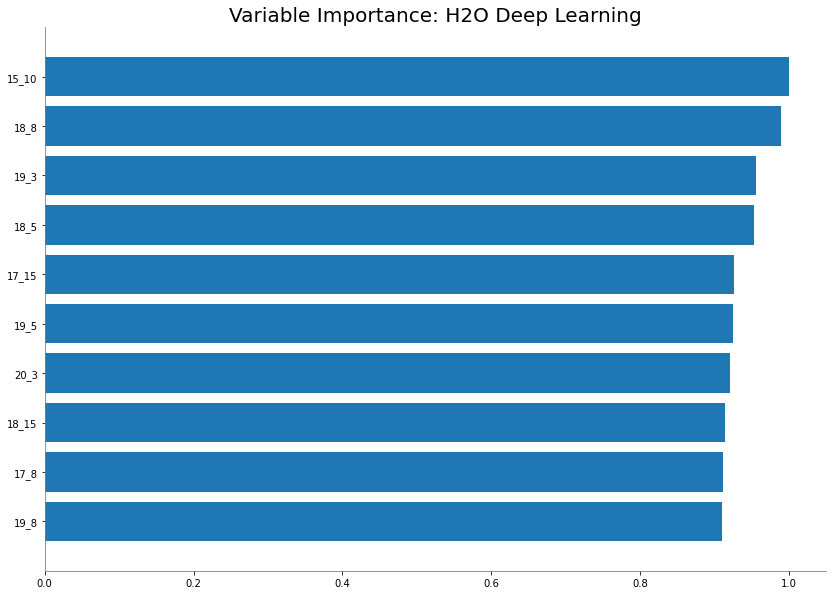

<Figure size 432x288 with 0 Axes>

In [ ]:
best_model.varimp_plot()

In [ ]:
# Retrieve the stored cross-validation (cv) holdout predictions
#cv_hold_predictions = best_model.predict(df_test).as_data_frame()
#cv_hold_predictions

In [ ]:
# Make cv_pred to a dataframe
as_data_frame_CV_predictions = best_model.cross_validation_holdout_predictions()
as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
as_data_frame_CV_predictions= as_data_frame_CV_predictions.as_data_frame()
as_data_frame_CV_predictions

,cv_holdout_predictions
0,0.000386
1,0.000085
2,0.000597
3,0.000043
4,0.000477
...,...
5439,0.000004
5440,0.000008
5441,-0.000171
5442,0.000014


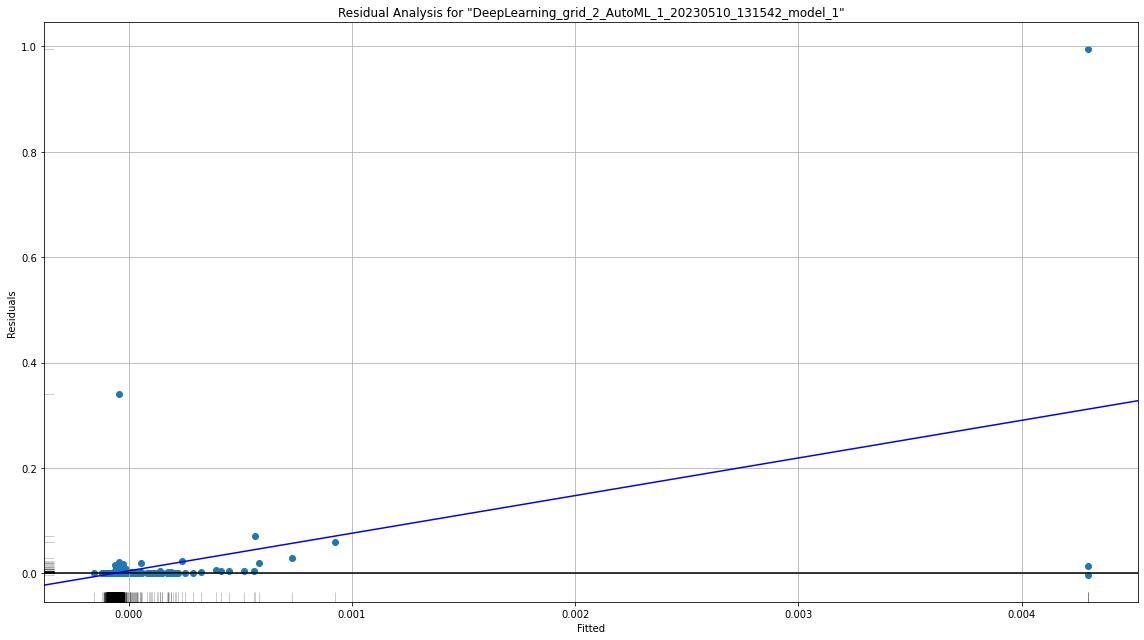

In [ ]:
best_model.residual_analysis_plot(df_test)

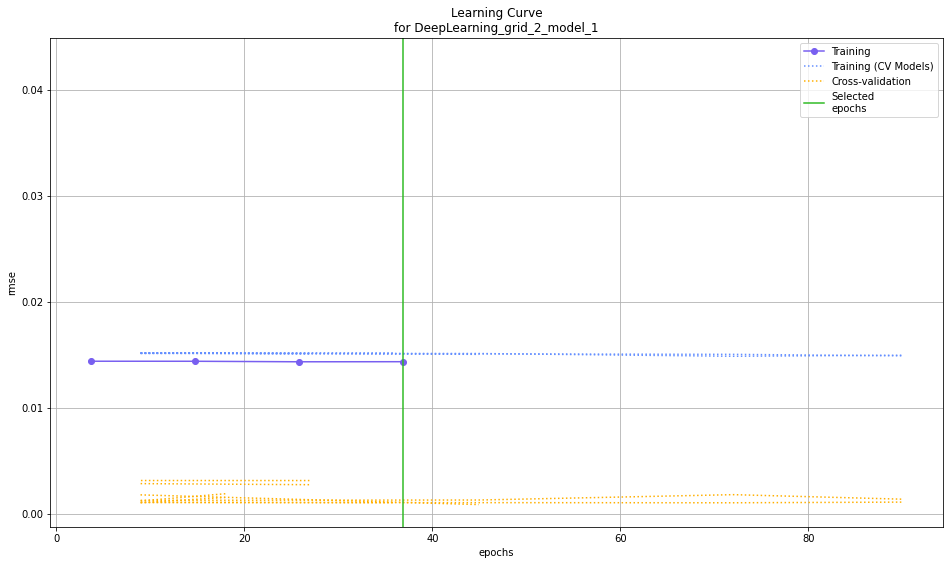

In [ ]:
learning_curve_plot = best_model.learning_curve_plot()

In [ ]:
best_model.cross_validation_metrics_summary()

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
mae,0.0008382,0.0006866,0.0020091,0.0007695,0.0004088,0.0004360,0.0013040,0.0017362,0.0012162,0.0001292,0.0001537,0.0002188
mean_residual_deviance,0.0002072,0.0005747,0.0018322,0.0002119,0.0000011,0.0000098,0.0000075,0.0000036,0.0000024,0.0000008,0.0000019,0.0000012
mse,0.0002072,0.0005747,0.0018322,0.0002119,0.0000011,0.0000098,0.0000075,0.0000036,0.0000024,0.0000008,0.0000019,0.0000012
r2,-0.4520113,0.9437150,-0.0003499,-0.0018507,-0.0421704,-0.0096730,-0.0774205,-2.9414532,-1.1649793,0.0045854,-0.1529585,-0.1338432
residual_deviance,0.0002072,0.0005747,0.0018322,0.0002119,0.0000011,0.0000098,0.0000075,0.0000036,0.0000024,0.0000008,0.0000019,0.0000012
rmse,0.0071073,0.0131960,0.0428036,0.0145575,0.0010523,0.0031351,0.0027433,0.0018907,0.0015405,0.0008707,0.0013776,0.0011016
rmsle,0.0055693,0.0091531,0.0296604,0.0125414,0.0010450,0.0030331,0.0026779,0.0018861,0.0015334,0.0008631,0.0013601,0.0010921


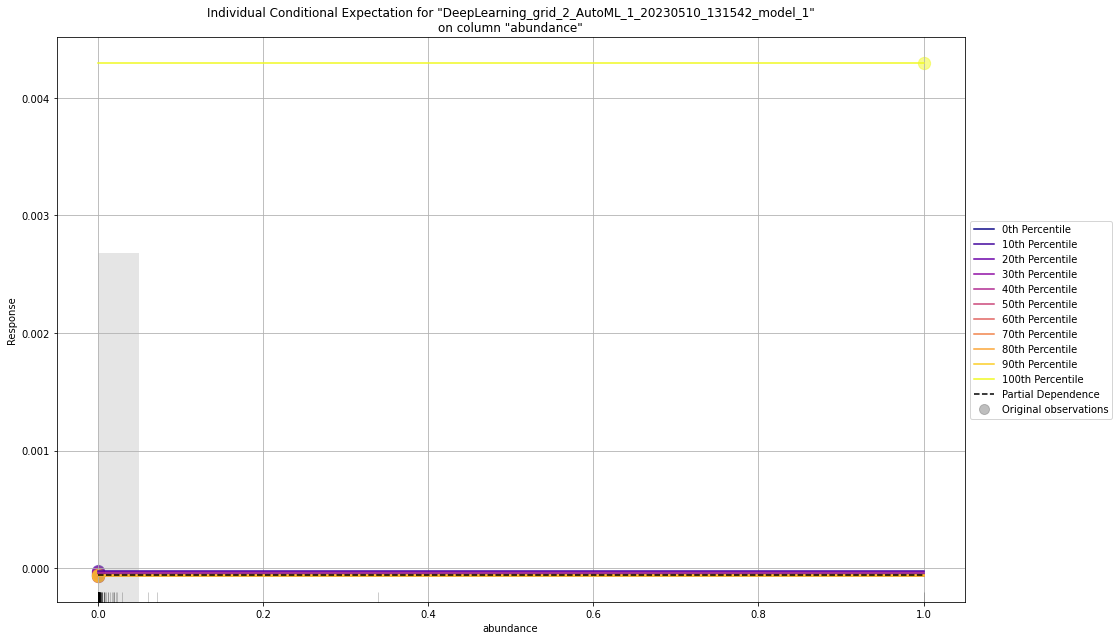

In [ ]:
best_model.ice_plot(df_test, 'abundance')

In [ ]:
# Convert df_test into a dataframe
df_test_as_df = df_test.as_data_frame()
type(df_test_as_df)

pandas.core.frame.DataFrame

In [ ]:
type(as_data_frame_CV_predictions)

pandas.core.frame.DataFrame

In [ ]:
df_test_as_df

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,abundance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339312
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.017628
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.071338
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.060200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.000000
5440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
5441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
5442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [ ]:
# Merge the cv holdout predictions together with the df_test abundance
df_signalP_cv_holdout = pd.merge(df_test_as_df, as_data_frame_CV_predictions, left_index=True, right_index=True)

# Order the dataframe in the descending order of abundance values
df_signalP_cv_holdout = df_signalP_cv_holdout.sort_values(by= 'abundance', ascending = False)

# Rename the predict column
#df_signalP_cv_holdout = df_signalP_cv_holdout.rename(columns={'binary_classification': 'cv_hold_predictions'})

# Reset the indexing of the dataframe
#df_signalP_cv_holdout = df_signalP_cv_holdout.reset_index()
df_signalP_cv_holdout


,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,abundance,cv_holdout_predictions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,0.000386
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.339312,0.000085
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.071338,0.000043
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.060200,0.000477
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.029343,0.001324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,1908,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000001
5440,1907,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,-0.000030
5441,1906,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,-0.000019
5442,1905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,-0.000135


In [ ]:
# Generate percentage ranking of the abundance and cv_predictions 
df_signalP_cv_holdout['abundance_ranked_pct'] = df_signalP_cv_holdout['abundance'].rank(pct=True)
df_signalP_cv_holdout['cv_ranked_pct'] = df_signalP_cv_holdout['cv_holdout_predictions'].rank(pct=True)
df_signalP_cv_holdout

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_15,21_16,21_17,21_18,21_19,21_20,abundance,cv_holdout_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.000386,1.000000,0.954445
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.339312,0.000085,0.999816,0.891807
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.071338,0.000043,0.999633,0.849743
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.060200,0.000477,0.999449,0.960691
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.029343,0.001324,0.999265,0.988244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,1908,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000001,0.486774,0.578802
5440,1907,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,-0.000030,0.486774,0.253490
5441,1906,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,-0.000019,0.486774,0.371969
5442,1905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,-0.000135,0.486774,0.115907


In [ ]:
from teemi.learn.plotting import correlation_plot

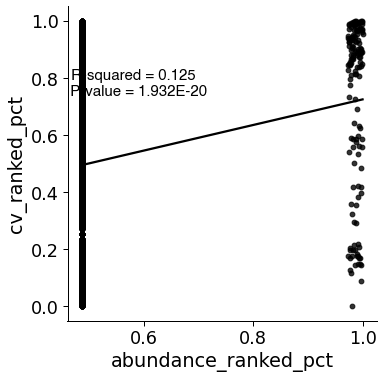

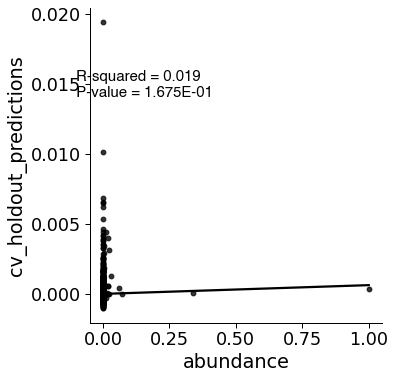

In [ ]:
correlation_plot(df_signalP_cv_holdout, 
                    x='abundance_ranked_pct',
                    y = "cv_ranked_pct", save_pdf = False , 
                 path ='G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank',
                 title = '',
                 size_height= 5, 
                 size_length = 5)

correlation_plot(df_signalP_cv_holdout, 
                    x='abundance',
                    y = "cv_holdout_predictions", save_pdf = False , 
                 path ='G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank',
                 title = '',
                 size_height= 5, 
                 size_length = 5)

In [ ]:
# Save the dataframe
df_signalP_cv_holdout.to_csv('../data/04_ML_models/cv_holdout_pred/DeepLearning_grid_1_AutoML_1_20230502_93454_model_1.csv')

## 5 Visualization of AutoML model

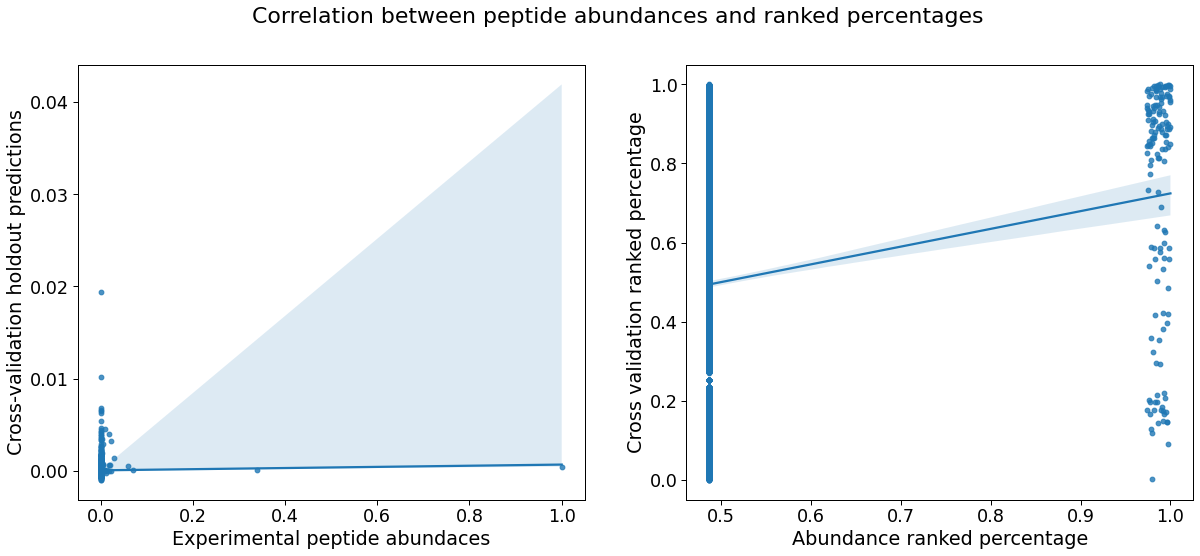

In [ ]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_holdout_predictions', data=df_signalP_cv_holdout, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [ ]:
# Drop rows where NaN values of the peptide abundance was set to 0 to reduce noise (i.e. create a dataframe without (wo) NaN/zero values)
df_signalP_cv_holdout_wo_NaNs = df_signalP_cv_holdout[df_signalP_cv_holdout['abundance'] != 0]
df_signalP_cv_holdout_wo_NaNs

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_16,21_17,21_18,21_19,21_20,abundance,cv_holdout_predictions,abundance_ranked_pct,cv_ranked_pct,color
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.000000,0.000386,1.000000,0.954445,black
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.339312,0.000085,0.999816,0.891807,black
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.071338,0.000043,0.999633,0.849743,black
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.060200,0.000477,0.999449,0.960691,black
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.029343,0.001324,0.999265,0.988244,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000005,0.000324,0.974284,0.947465,black
141,142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000003,0.000039,0.974100,0.843865,black
142,120,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000003,-0.000047,0.973916,0.176708,black
143,103,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000002,0.000266,0.973641,0.940852,black


In [ ]:
# # Set the font size before creating any plot elements
# plt.rc('font', size=20)

# # Create a figure with 2 subplots side by side
# fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
# fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# # Left subplot
# sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[0])
# axs[0].set_xlabel('Experimental peptide abundaces')
# axs[0].set_ylabel('Cross-validation holdout predictions')

# # Right subplot
# sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[1])
# axs[1].set_xlabel('Abundance ranked percentage')
# axs[1].set_ylabel('Cross validation ranked percentage')

# plt.show()

In [ ]:
# Save the resulting dataframe
#df_signalP_cv_holdout_wo_NaNs.to_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/06.3_Cv_holdout_predictions/Second_round/DeepLearning_grid_1_AutoML_1_20230501_95004_model_3.csv', index=False)

In [417]:
h2o.shutdown()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1011/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


H2O session _sid_bfa0 closed.
